### Exploratory Data Analysis

In this workbook, we will discover some fundamental EDA techniques for text data: 
- Counts and Lengths: Countr of words and sentences, their length and average length
- Term Frequency Analysis: Most frequently occuring words and n_grams

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer

In [39]:
df_raw = pd.read_excel("amazon_review_clean.xlsx")
df_raw.head(5)

,Review Model,Retailer,Review date,Review name,Review rating,Review title,Review Content,Verified Purchase or not,People_find_helpful,vine or not,URL,list price,rating count,overall rating
0,Canon Pixma TS6420a,Amazon,2023-08-10,Ernest Birkholz,5,Works great,🖨 was easy to install and works great.,Verified Purchase,NaN,NaN,https://www.amazon.com/product-reviews/B09TG52...,129.99,285,4.2
1,HP OfficeJet Pro 9015e,Amazon,2022-06-04,mattey,3,spunky mid size printer,🔆Slower print speed than what I’m used to (old...,Verified Purchase,NaN,NaN,https://www.amazon.com/product-reviews/B08QR6P...,289.99,285,4.2
2,Canon PIXMA MG3620,Amazon,2023-03-15,Maria D,4,𝙲𝚕𝚎𝚊𝚛 𝚙𝚛𝚒𝚗𝚝𝚜,𝙻𝚘𝚟𝚎 𝚒𝚝,Verified Purchase,NaN,NaN,https://www.amazon.com/Canon-MG3620-Wireless-P...,79.99,285,4.2
3,Epson - ET-3830,Amazon,2022-11-17,Ryan H,5,Shaq knows what he's talking about,"Yup, this printer is a slam dunk. :)What an up...",Verified Purchase,12.0,NaN,https://www.amazon.com/product-reviews/B096NBP...,399.99,285,4.2
4,HP ENVY 6055e,Amazon,2022-04-09,Sam,3,Not User Friendly,You would think something as simple as reconne...,Verified Purchase,NaN,NaN,https://www.amazon.com/product-reviews/B08XYRV...,129.99,285,4.2


In [31]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10209 entries, 0 to 10208
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Review Model              10209 non-null  object        
 1   Retailer                  10209 non-null  object        
 2   Review date               10209 non-null  datetime64[ns]
 3   Review name               10152 non-null  object        
 4   Review rating             10209 non-null  int64         
 5   Review title              10028 non-null  object        
 6   Review Content            10198 non-null  object        
 7   Verified Purchase or not  9425 non-null   object        
 8   People_find_helpful       3905 non-null   float64       
 9   vine or not               265 non-null    object        
 10  URL                       10209 non-null  object        
 11  list price                10209 non-null  float64       
 12  rating count      

In [40]:
df_raw["Review rating"].value_counts()

5    3011
1    2663
4    1642
2    1473
3    1420
Name: Review rating, dtype: int64

In [41]:
def ratings(rating):
    if rating > 3 and rating <= 5: 
        return "Positive"
    elif rating > 0 and rating <= 3:
        return "Negative"

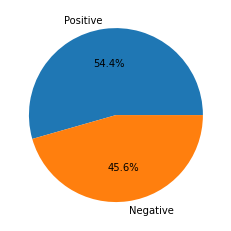

In [42]:
# Obtaining the split between Positive and Negative ratings
df_raw["Review rating"] = df_raw["Review rating"].apply(ratings)
plt.pie(df_raw["Review rating"].value_counts(), labels = df_raw["Review rating"].unique().tolist(), autopct='%1.1f%%')
plt.show()